In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
import pickle
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### Import auto stuff
import autoutils
import auto
### Linear algebra
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
### to create temp files in every run
import contextlib
import tempfile
import shutil




matplotlib.rc('font', family='serif', size=25)

In [2]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [3]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [4]:
def saving_pdf_figure(fig,fig_name,md_dir):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    ax.savefig(fig_name+'.png',dpi=200)
    fig.savefig(pdffig, format="pdf")
    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [5]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto
def get_expressions(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    return var,rhs,spikecriterion,J

# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

In [6]:
from scipy.optimize import curve_fit

def func_lambdas(l0,bifpar,autobifpart,saddle,stable,limit_cycle):
    ################################################
    ###### Getting lambdas (eigenvalues) in each stable state (the lambda corresponding to l0..)
    ################################################
    lam_st=[]
    lam_lc=[]

    var,rhs,spikecriterion,J=get_expressions(neuron_snap,bifpar,autobifpart)
    dd={}
    iic=0
    for iis in var:
        dd[iis]=str(stable[iic][0])
        iic+=1

    matJ_stable=np.zeros(np.shape(J))
    for iii in range(np.shape(J)[0]):
        for jjj in range(np.shape(J)[1]):
            matJ_stable[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
    
    dd={}
    iic=0
    for iis in var:
        dd[iis]=str(saddle[iic][0])
        iic+=1

    matJ_saddle=np.zeros(np.shape(J))
    for iii in range(np.shape(J)[0]):
        for jjj in range(np.shape(J)[1]):
            matJ_saddle[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd) 
            
    ii_min=np.argmin(np.dot(l0,limit_cycle-saddle)) 
    ll=limit_cycle[:,ii_min]

    dd={}
    iic=0
    for iis in var:
        dd[iis]=str(ll[iic])
        iic+=1

    matJ_lc=np.zeros(np.shape(J))
    for iii in range(np.shape(J)[0]):
        for jjj in range(np.shape(J)[1]):
            matJ_lc[iii][jjj]=S(str(S(str(J[iii][jjj])).subs(autobifpart))).subs(dd)

    lam_st=LA.eig(matJ_stable)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    lam_lc=LA.eig(matJ_lc)[0][np.argmax(LA.eig(matJ_saddle)[0])]
    
    return lam_st,lam_lc



In [7]:
# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])
    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

def extracting_phase_plane_info(ss,lc,J):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_fixed_point=[]
    v_I_app_ss=[]
    for ao_fixed_point in ss:
        ### Getting position
        fixed_point=ao_fixed_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_fixed_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_fixed_point.coordnames,J)
        Jmat=Jfoo(*fixed_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(m_JMat)
        v_fixed_point.append(fixed_point)
        v_Jeival.append(Jeival)
        v_Jeivect.append(Jeivect)
        v_I_app_ss.append(ao_fixed_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point
        

In [8]:
def extracting_left_eigenvectors(ss,lc,J):
    ## Limir cycle info
    v_I_app_lc=[]
    v_one_sim_s_lc=[]
    v_one_sim_lc=[]
    for lc_Iapp_specfi in lc:
        one_sim=[]
        one_sim_s=[]
        for i_s in lc_Iapp_specfi.coordnames:
            one_sim.append(lc_Iapp_specfi[i_s])
            one_sim_s.append(i_s)
        v_I_app_lc.append(lc_Iapp_specfi.PAR[strIapp])
        v_one_sim_s_lc.append(one_sim_s)
        v_one_sim_lc.append(one_sim)
    ## Extracting information from auto objects into numpy arrays
    # steady states
    v_Jeival=[]
    v_Jeivect=[]
    v_saddle_point=[]
    v_I_app_ss=[]
    for ao_saddle_point in ss:
        ### Getting position
        saddle_point=ao_saddle_point.coordarray
        ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
        v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
        J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
        Jfoo = lambdify(ao_saddle_point.coordnames,J)
        Jmat=Jfoo(*saddle_point)
        m_JMat=fixing_jmat(Jmat)
        Jeival, Jeivect = LA.eig(np.matrix(m_JMat).transpose())
        v_saddle_point.append(saddle_point)
        v_Jeival.append(copy(Jeival))
        v_Jeivect.append(copy(Jeivect))
        v_I_app_ss.append(ao_saddle_point.PAR[strIapp])
        
    return v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_saddle_point,m_JMat


In [10]:
## defining neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)

### Importing data created in Bifurcation_Graph_Ko.ipynb

In [11]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

In [12]:
v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

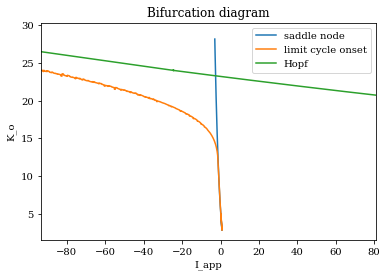

In [13]:
s_x=1;s_y=0
plt.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],label='saddle node')
plt.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],label='limit cycle onset')
plt.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],label='Hopf')
plt.ylabel(v_s_par[s_y])
plt.xlabel(v_s_par[s_x])
plt.xlim(min(m_res_par_lc_KoIapp[s_x]), max(m_res_par_sn_KoIapp[s_x])+80)
plt.title('Bifurcation diagram')
plt.legend()
plt.show()


# Mixing factor for different locations of the plane

### First we create a mesh inside the bi-stable region

In [14]:
### Finding mesh boundaries...

from scipy.interpolate import interp1d
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
### Finding relation between Ko and lc onset (Iapp) ..
f2x_lc = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
snl_ko=b[b.argsort()][np.nonzero(f2x_lc(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x])][-1]
### Finding relation between Ko and sn (Iapp) ..
a=m_res_par_sn_KoIapp[s_x]
f2x_sn = interp1d(m_res_par_sn_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
### Finding relation between Hf and (Iapp) ..
a=m_res_par_HF0[s_y]
f2y_hf = interp1d(m_res_par_HF0[s_x][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_HF0[s_y]), bounds_error=False)


In [16]:
 
### Creating mesh
dot_comb=[]
for t_ko_i in np.concatenate([np.linspace(snl_ko,max(m_res_par_HF0[s_y]),30),np.array([12.0,13.0,14.0])]):
    for t_I_app_i in np.linspace(f2x_lc(t_ko_i),f2x_sn(t_ko_i),30):
        if t_ko_i<f2y_hf(t_I_app_i) and t_I_app_i>f2x_lc(t_ko_i) and t_I_app_i<f2x_sn(t_ko_i):
            dot_comb.append([[t_I_app_i],[t_ko_i]])
    
            


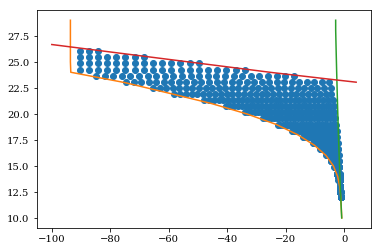

In [17]:
### Picture created grid
plt.plot(np.concatenate(dot_comb,axis=1)[0],np.concatenate(dot_comb,axis=1)[1],'o')
plt.plot(f2x_lc(range(30)[10:]),range(30)[10:])
plt.plot(f2x_sn(range(30)[10:]),range(30)[10:])
plt.plot(range(-100,5),f2y_hf(range(-100,5)))
plt.show()

### Second. Get the steady states of each combination with auto

In [18]:
name='Phase_planes_4all_summary_'+model_name
if os.path.isfile(dir_sims+name+'.pkl'):
    pass
else:
    cwd_nonTemp = os.getcwd()
    a_ss_I_app_specf=[]
    a_lc_Iapp_specf=[]
    a_t_I_app_specf=[]
    ### Getting phase response curves for each combination
    aa=np.concatenate(dot_comb,axis=1)[1][np.concatenate(dot_comb,axis=1)[1].argsort()]
    Ko_vv=np.unique(aa)
    for Ko_ii in Ko_vv:
        t_I_app_specf=[]
        for combi in dot_comb:
            if combi[1][0]==Ko_ii:
                t_I_app_specf.append(combi[0][0])

        ##############################################3
        ### Finding phase plane in the bistable region
        I_app=min(t_I_app_specf)-5;K_o=Ko_ii
        ## Defining Bifurcation parameters.. (In our case I_app and Ko)
        bifpar={}
        autobifpart={}
        bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
        autobifpart[strIapp]=I_app
        bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
        autobifpart['K_o']=K_o
        ### Extracting inistates & expressions
        var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
        with TemporaryDirectory(suffix="trial0"+str(Ko_ii)) as t:
            ##############################333##############################333##############################333
            ##############                # Writing Auto readable files                   ###########333#
            ##############################333##############################333##############################333
            automodelname='autoOrbitSpike_'+model_name
            unames,pnames= autoutils.writeFP(automodelname,
                bifpar=autobifpart, rhs=rhs, var=var,
                bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
                ic=[])
            #############################################################
            ##### Using AUTO to Continue steady state
            # Continuing Forward (ds>0) in I_app   
            r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
                PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
                DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
                UZSTOP= {})
            s1HB = r1_fwd_sn_I_app_specf('HB')[0]
            r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
                ITNW=17, NWTN=13, NMX=100000, NPR=3000,
                DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
                SP=['BT','LP','HB','BP','CP'],
                UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})

        ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
        lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')
        a_ss_I_app_specf.append(ss_I_app_specf)
        a_lc_Iapp_specf.append(lc_Iapp_specf)
        a_t_I_app_specf.append(t_I_app_specf)
        os.chdir(cwd_nonTemp)


### Third. Extract information from auto objects

In [22]:
#### To derive plot dlc... 

name='Phase_planes_4all_summary_'+model_name
if os.path.isfile(dir_sims+name+'.pkl'):
    f=open(dir_sims+name+'.pkl', 'rb')
    d_res_phase_planes=pickle.load(f)
    a_dlc=d_res_phase_planes['dlc']
    a_dsn=d_res_phase_planes['dsn']
    a_ko=d_res_phase_planes['ko']
    Ko_vv=np.unique(np.concatenate(a_ko))
    a_iapp=d_res_phase_planes['iapp']
    a_period=d_res_phase_planes['period']
    a_l0=d_res_phase_planes['L0']
    a_lam0=d_res_phase_planes['lam0']
    a_lam_saddle=d_res_phase_planes['lam_saddle']
    a_saddle=d_res_phase_planes['saddle']
    a_El_saddle=d_res_phase_planes['El_saddle']
    a_Er_saddle=d_res_phase_planes['Er_saddle']
    a_stable=d_res_phase_planes['stable']
    a_lam_stable=d_res_phase_planes['lam_stable']
    a_one_lc=d_res_phase_planes['one_lc']
    v_one_sim_s_lc=d_res_phase_planes['s_one_lc']

else:
    a_dlc=[]
    a_dsn=[]
    a_ko=[]
    a_iapp=[]
    a_period=[]
    a_l0=[]
    a_lam0=[]
    a_lam_saddle=[]
    a_saddle=[]
    a_El_saddle=[]
    a_Er_saddle=[]
    a_stable=[]
    a_lam_stable=[]
    a_one_lc=[]
    for iikoi in range(len(Ko_vv)):
        ## Extracting info from each auto object
        Ko_ii=Ko_vv[iikoi]
        ss_I_app_specf=a_ss_I_app_specf[iikoi]
        lc_Iapp_specf=a_lc_Iapp_specf[iikoi]
        t_I_app_specf=a_t_I_app_specf[iikoi]
        v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,rv_Jeival,rv_Jeivect,v_fixed_point=extracting_phase_plane_info(ss_I_app_specf,lc_Iapp_specf,J)
        del(v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc)
        v_I_app_ss,v_I_app_lc,v_one_sim_s_lc,v_one_sim_lc,v_Jeival,v_Jeivect,v_fixed_point,m_Jmat=extracting_left_eigenvectors(ss_I_app_specf,lc_Iapp_specf,J)
        v_dlc=[]
        v_ko=[]
        v_iapp=[]
        v_dsn=[]
        v_period=[]
        v_lam0=[]
        v_l0=[]
        v_lam_saddle=[]
        v_saddle=[]
        v_El_saddle=[]
        v_Er_saddle=[]
        v_stable=[]
        v_lam_stable=[]
        v_one_lc=[]

        for ii_iapi in range(len(t_I_app_specf)):
            saddle=[]
            stable=[]
            lam_stable=[]
            lam_saddle=[]
            Er_saddle=[]
            El_saddle=[]
            dlc=[]
            yn=[]
            ys_0=[]
            period_i=[]
            one_lc=[]
            l0=[]
            lam0=[]
            
            for ii_api_lc in range(len(v_I_app_lc)):
                ## Extracting info from LC
                if abs(v_I_app_lc[ii_api_lc]-t_I_app_specf[ii_iapi])<np.diff(t_I_app_specf)[0]/2:
                    try:
                        one_lc=v_one_sim_lc[ii_api_lc]
                        period_i=lc_Iapp_specf[ii_api_lc].PAR['period']
                    except:
                        pass

            for ii_api_ss in range(len(v_I_app_ss)):
                ## Extracting info from fixed points
                if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<np.diff(t_I_app_specf)[0]/2:
                    if sum(v_Jeival[ii_api_ss].real>0)==1:
                        ## Extracting eigenvalues and eigenvectors at the saddle node
                        saddle=v_fixed_point[ii_api_ss]
                        El_saddle=v_Jeivect[ii_api_ss]
                        Er_saddle=rv_Jeivect[ii_api_ss]
                        lam_saddle=v_Jeival[ii_api_ss]
                    if sum(v_Jeival[ii_api_ss].real>0)==0:
                        ## Extracting eigenvalues and eigenvectors at the stable fixed node
                        stable=v_fixed_point[ii_api_ss]
                        lam_stable=v_Jeival[ii_api_ss]

            if one_lc!=[]:
                argsort = [j for j, k in sorted(enumerate(lam_saddle), key=lambda x:x[1], reverse=1)]
                lam = [lam_saddle[k] for k in argsort]
                lam0=lam[0]
                ## Extracting l0 from the left eigenvectors at the saddle node
                l0=np.concatenate(np.array(El_saddle[:,lam_saddle>0]))
                ## projecting the stable fixed point and the saddle in l0
                ys_0=np.dot(l0,saddle)[0]
                yn=np.dot(l0,stable)[0]
                if yn>0 and yn>ys_0:
                    l0=-l0
                    ys_0=np.dot(l0,saddle)[0]
                    yn=np.dot(l0,stable)[0]

                ## Getting the minimal distance from the limit cycle to the saddle node in the l0 direction
                dlc=min(np.dot(l0,one_lc-saddle))
                if dlc<0 and max(np.dot(l0,one_lc-saddle))<0:
                    dlc=min(abs(np.dot(l0,one_lc-saddle)))

                v_dlc.append(dlc)
                v_dsn.append(yn-ys_0)
                v_ko.append(Ko_vv[iikoi])
                v_iapp.append(t_I_app_specf[ii_iapi])
                v_period.append(period_i)
                v_one_lc.append(one_lc)

                v_saddle.append(saddle)
                v_lam_saddle.append(lam_saddle)
                v_El_saddle.append(El_saddle)
                v_Er_saddle.append(Er_saddle)
                v_stable.append(stable)
                v_lam_stable.append(lam_stable)

                v_l0.append(l0)
                v_lam0.append(lam0)
            

        a_dlc.append(v_dlc)
        a_dsn.append(v_dsn)
        a_ko.append(v_ko)
        a_iapp.append(v_iapp)
        a_period.append(v_period)
        a_one_lc.append(v_one_lc)
        
        a_saddle.append(v_saddle)
        a_lam_saddle.append(v_lam_saddle)
        a_El_saddle.append(v_El_saddle)
        a_Er_saddle.append(v_Er_saddle)
        a_stable.append(v_stable)
        a_lam_stable.append(v_lam_stable)
        
        a_l0.append(v_l0)
        a_lam0.append(v_lam0)
        
        
        
        
    d_res_phase_planes={}
    d_res_phase_planes['dlc']=a_dlc
    d_res_phase_planes['dsn']=a_dsn
    d_res_phase_planes['ko']=a_ko
    d_res_phase_planes['iapp']=a_iapp
    d_res_phase_planes['period']=a_period
    d_res_phase_planes['L0']=a_l0
    d_res_phase_planes['lam0']=a_lam0
    d_res_phase_planes['lam_saddle']=a_lam_saddle
    d_res_phase_planes['saddle']=a_saddle
    d_res_phase_planes['El_saddle']=a_El_saddle
    d_res_phase_planes['Er_saddle']=a_Er_saddle
    d_res_phase_planes['stable']=a_stable
    d_res_phase_planes['lam_stable']=a_lam_stable
    d_res_phase_planes['one_lc']=a_one_lc
    d_res_phase_planes['s_one_lc']=v_one_sim_s_lc

    name='Phase_planes_4all_summary_'+model_name
    save_obj(d_res_phase_planes, dir_sims+name)

In [24]:
import matplotlib.ticker as ticker
import json
### Importing the thesis format for figures..
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

### Fourth. Plot & save results

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


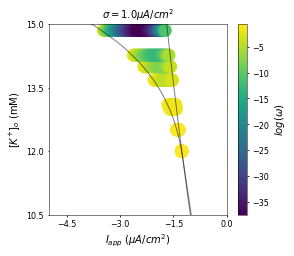

<Figure size 410.4x360 with 0 Axes>

In [52]:
f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide*0.7,fig_height*0.7))

## Bif lines
xlim=[-80,1]
ylim=[10,28]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=1,color=[0,0,0],alpha=0.5)
##

sigma_v=[si_v[1],0,0,0]                       
# v_w=1/2*(1-erf(np.sqrt(np.concatenate(a_lam0))*np.concatenate(a_dlc)/abs(np.dot(np.concatenate(a_l0),sigma_v))))
v_w=1/2*(1-erf(np.sqrt(np.concatenate(a_lam0))*np.concatenate(a_dlc)/(2*abs(np.dot(np.concatenate(a_l0),sigma_v))**2)))

sc=ax.scatter(np.concatenate(a_iapp),np.concatenate(a_ko),c=np.log(v_w),s=150)
ax.set_title('$\sigma=$'+str(sigma_v[0])+'$\mu A/cm^2$')
ax.set_ylabel('$[K^{+}]_o$ (mM)')
ax.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
cbar = plt.colorbar(sc)
cbar.set_label('$log(\omega)$')

#### Changing number of ticks
locatorx1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)
locatory1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)


fig_name='log_Mixing_Factor_'+model_name+'_sigma_'+str(int(si_v[1]))

md_dir={}
md_dir['Title']='log Mixing Factor For bistable region'+model_name+' sigma='+str(si_v)+'muA'
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


ax.set_xlim([-5,0.0])
ax.set_ylim([10.5,15.0])
saving_pdf_figure(f11,'./Figs/'+fig_name,md_dir)

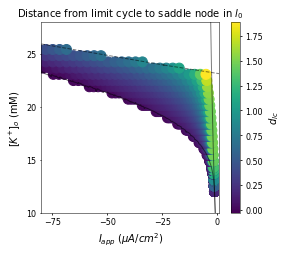

<Figure size 410.4x360 with 0 Axes>

In [53]:
plt.close('all')

f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide*0.7,fig_height*0.7))

## Bif lines
xlim=[-80,1]
ylim=[10,28]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=1,color=[0,0,0],alpha=0.5)
##

sc=ax.scatter(np.concatenate(a_iapp),np.concatenate(a_ko),c=np.concatenate(a_dlc),s=100)
ax.set_title('Distance from limit cycle to saddle node in $l_0$')
ax.set_ylabel('$[K^{+}]_o$ (mM)')
ax.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
cbar = plt.colorbar(sc)
cbar.set_label('$d_{lc}$')

fig_name='dlc_'+model_name

md_dir={}
md_dir['Title']='distance from limit cycle to saddle node projected in l0 For bistable region'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

#### Changing number of ticks
locatorx1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)
locatory1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)

saving_pdf_figure(f11,'./Figs/'+fig_name,md_dir)

plt.show()

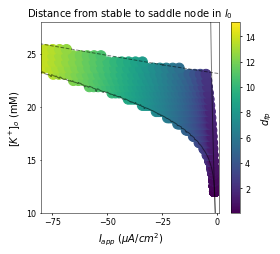

<Figure size 410.4x360 with 0 Axes>

In [54]:

f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide*0.7,fig_height*0.7))

## Bif lines
xlim=[-80,1]
ylim=[10,28]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=1,color=[0,0,0],alpha=0.5)
##

sc=ax.scatter(np.concatenate(a_iapp),np.concatenate(a_ko),c=abs(np.concatenate(a_dsn)),s=100)
ax.set_title('Distance from stable to saddle node in $l_0$')
ax.set_ylabel('$[K^{+}]_o$ (mM)')
ax.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
cbar = plt.colorbar(sc)
cbar.set_label(r'$d_{fp}$')

fig_name='dss_'+model_name

md_dir={}
md_dir['Title']='distance from steady state to saddle node projected in l0 For bistable region'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

#### Changing number of ticks
locatorx1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)
locatory1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)

saving_pdf_figure(f11,'./Figs/'+fig_name,md_dir)

plt.show()

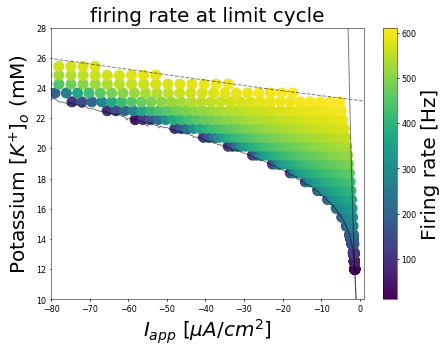

In [32]:


f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(7,5))

## Bif lines
xlim=[-80,1]
ylim=[10,28]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5, rasterized=True)
ax.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5, rasterized=True)
ax.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=1,color=[0,0,0],alpha=0.5, rasterized=True)
##


sc=ax.scatter(np.concatenate(a_iapp),np.concatenate(a_ko),c=1000.0/np.concatenate(a_period),s=100, rasterized=True)
ax.set_title('firing rate at limit cycle',fontsize=20)
ax.set_ylabel('Potassium $[K^{+}]_o$ (mM)',fontsize=20)
ax.set_xlabel('$I_{app}$ $[\mu A/cm^2]$',fontsize=20)
cbar = plt.colorbar(sc)
cbar.set_label('Firing rate [Hz]',fontsize=20)

fig_name='period_lc_fr_'+model_name

md_dir={}
md_dir['Title']='period limit cycle For bistable region'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

# saving_pdf_figure(f11,'./Figs/'+fig_name,md_dir)

plt.show()

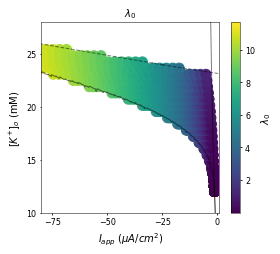

<Figure size 410.4x360 with 0 Axes>

In [33]:

f11, ax= plt.subplots(1, sharex=True,sharey=True, facecolor="1",figsize=(fig_wide*0.7,fig_height*0.7))

## Bif lines
xlim=[-80,1]
ylim=[10,28]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=1,color=[0,0,0],alpha=0.5)
ax.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=1,color=[0,0,0],alpha=0.5)
##


sc=ax.scatter(np.concatenate(a_iapp),np.concatenate(a_ko),c=np.concatenate(a_lam0),s=100)
ax.set_title('$\lambda_0$ ')
ax.set_ylabel('$[K^{+}]_o$ (mM)')
ax.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
cbar = plt.colorbar(sc)
cbar.set_label('$\lambda_0$')

#### Changing number of ticks
locatorx1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.xaxis.set_major_locator(locatorx1)
locatory1 = ticker.MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)


fig_name='lam0_'+model_name

md_dir={}
md_dir['Title']='magnitude of unstable eigenvalue For bistable region'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f11,'./Figs/'+fig_name,md_dir)

plt.show()
